# IMDB - GloVe with LSTM

> ## NLP(Natural Language Processing

In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
import keras
keras.__version__


'2.4.3'

# I. IMDB Data_Set

> ## 1) Load IMDB Data_Set

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/datasets/IMDB.zip 


-rw------- 1 root root 60711700 Mar 31 06:44 '/content/drive/My Drive/Colab Notebooks/datasets/IMDB.zip'


In [5]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/IMDB.zip


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: __MACOSX/aclImdb/train/pos/._7754_9.txt  
  inflating: aclImdb/train/pos/7755_9.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7755_9.txt  
  inflating: aclImdb/train/pos/7756_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7756_10.txt  
  inflating: aclImdb/train/pos/7757_9.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7757_9.txt  
  inflating: aclImdb/train/pos/7758_7.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7758_7.txt  
  inflating: aclImdb/train/pos/7759_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7759_10.txt  
  inflating: aclImdb/train/pos/775_7.txt  
  inflating: __MACOSX/aclImdb/train/pos/._775_7.txt  
  inflating: aclImdb/train/pos/7760_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7760_10.txt  
  inflating: aclImdb/train/pos/7761_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7761_10.txt  
  inflating: aclImdb/train/pos/7762_8.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7762_8.txt  
  inflating:

> ## 2) 'tests' and 'labels' Data

* 'texts': 문자열 리스트(영화 감상평)
* 'labels': 감상평 리뷰(긍정/부정)

In [6]:
import os

imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding = 'utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
len(texts), len(labels)


(25000, 25000)

# II. Tensor Tranformation

> ## 1) X_train and X_valid: (25000, 2000)

* vectorization
  * (25000, 2000)

In [8]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 2000       # 2000개 단어까지 적용
max_words = 10000   # 빈도 높은 10000개 단어 사용

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

# (25000, 2000)으로 패딩
data = pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

# 샘플 데이터 랜덤화
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# 데이터를 훈련 세트와 검증 세트로 분할
training_samples = 15000            # 훈련 샘플은 15000개
validation_samples = 10000          # 검증 샘플은 10000개
X_train = data[:training_samples]
y_train = labels[:training_samples]
X_valid = data[training_samples: training_samples + validation_samples]
y_valid = labels[training_samples: training_samples + validation_samples]




88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 2000)
레이블 텐서의 크기: (25000,)


# III. Glove(Global Vectors for word representation

* 영문 위키디피아를 사용한 사전 임베딩
* https://nlp.stanford.edu/projects/glove/


> ## 1) 'Glove.zip' 압축 풀기

In [9]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/datasets/GloVe.zip 


-rw------- 1 root root 862182613 Mar 31 06:45 '/content/drive/My Drive/Colab Notebooks/datasets/GloVe.zip'


In [10]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/GloVe.zip


Archive:  /content/drive/My Drive/Colab Notebooks/datasets/GloVe.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


> ## 2) 'glove.6B.100d.txt' 사전 학습 임베딩


* glove.6B.100d.txt' 파일 파싱
  * 단어에 매핑되는 표현벡터 인덱스 생성


In [12]:
import numpy as np
import os

glove_dir = '.'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding = 'utf8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype = 'float32')
  embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.' % len(embeddings_index))


400000개의 단어 벡터를 찾았습니다.


In [14]:
# 매핑 확인

embeddings_index['apple'].shape

(100,)

> ## 3) 임베딩 행렬 생성

* (10000, 100)

In [16]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # 임베딩 인덱스에 없는 단어는 모두 0이 됨
            embedding_matrix[i] = embedding_vector


In [17]:
# 확인

embedding_matrix.shape

(10000, 100)

# IV. Keras Embedding Modeling

> ## 1) Model Define

* 모델 신경망 구조 정의
  * Embedding Dimension: 100

In [18]:
from keras import models
from keras import layers

imdb = models.Sequential()

imdb.add(layers.Embedding(max_words,
                          embedding_dim,
                          input_length = maxlen))

imdb.add(layers.LSTM(16))
imdb.add(layers.Dropout(0.5))
imdb.add(layers.Dense(1, activation = 'sigmoid'))

* 'GloVe' Embedding Load
  * Embedding Layer의 Parameters 동결

In [19]:
imdb.layers[0].set_weights([embedding_matrix])
imdb.layers[0].trainable = False


In [21]:
imdb.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 16)                7488      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,007,505
Trainable params: 7,505
Non-trainable params: 1,000,000
_________________________________________________________________


> ## 2) Model Comple

In [25]:
# 모델 학습방법 설정
imdb.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

> ## 3) Model Fit

In [26]:
%%time

Hist_imdb = imdb.fit(X_train, y_train,
                     epochs = 100,
                     batch_size = 512,
                     validation_data = (X_valid, y_valid))


Epoch 1/100
30/30 [==============================] - 40s 250ms/step - loss: 0.6955 - accuracy: 0.5310 - val_loss: 0.6709 - val_accuracy: 0.6046
Epoch 2/100
30/30 [==============================] - 7s 234ms/step - loss: 0.6661 - accuracy: 0.5941 - val_loss: 0.6159 - val_accuracy: 0.6721
Epoch 3/100
30/30 [==============================] - 7s 235ms/step - loss: 0.5887 - accuracy: 0.7066 - val_loss: 0.5446 - val_accuracy: 0.7351
Epoch 4/100
30/30 [==============================] - 7s 235ms/step - loss: 0.5481 - accuracy: 0.7454 - val_loss: 0.5146 - val_accuracy: 0.7562
Epoch 5/100
30/30 [==============================] - 7s 235ms/step - loss: 0.5230 - accuracy: 0.7637 - val_loss: 0.4967 - val_accuracy: 0.7685
Epoch 6/100
30/30 [==============================] - 7s 234ms/step - loss: 0.5022 - accuracy: 0.7745 - val_loss: 0.6318 - val_accuracy: 0.6746
Epoch 7/100
30/30 [==============================] - 7s 235ms/step - loss: 0.6180 - accuracy: 0.6809 - val_loss: 0.5219 - val_accuracy: 0.755

> ## 4) 학습 결과 시각화

In [27]:
# Loss Visualization

import matplotlib.pyplot as plt

epochs = range(1, len(Hist_imdb.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_imdb.history['loss'])
plt.plot(epochs, Hist_imdb.history['val_loss'])
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()


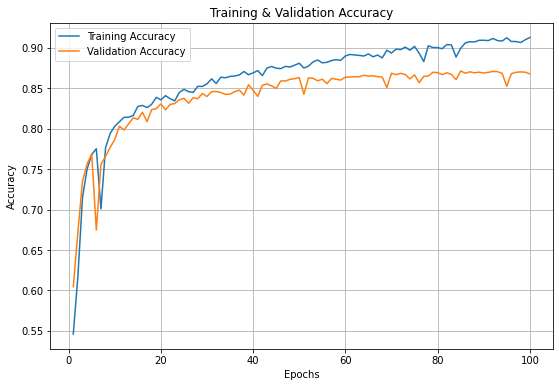

In [28]:
# Accuracy Visualization

import matplotlib.pyplot as plt

epochs = range(1, len(Hist_imdb.history['accuracy']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_imdb.history['accuracy'])
plt.plot(epochs, Hist_imdb.history['val_accuracy'])
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

> ## 5) Model Evaluate

In [29]:
# Loss & Accuracy

loss, accuracy = imdb.evaluate(X_valid, y_valid)
print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))


313/313 [==============================] - 9s 28ms/step - loss: 0.3431 - accuracy: 0.8677
Loss = 0.34309
Accuracy = 0.86770
